<a href="https://colab.research.google.com/github/T-Emmanuel/Breast-Mamography-Analysis/blob/main/Ultrasound_Based_(Mamography)_Breast_Cancer_Detection_and_Segmentation_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ultrasound-Based Breast Cancer Detection

In [ ]:
# Install segmentation models package
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.7 MB/s eta 0:00:00


## Load the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Unzip the Dataset

In [ ]:
!unzip "/content/gdrive/MyDrive/data/PRECISE_Challenge2025_Train.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00730_001_BUSBRA.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00730_001_BUSBRA_mask.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00731_001_BUSBRA.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00731_001_BUSBRA_mask.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00732_001_BUSBRA.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00732_001_BUSBRA_mask.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00733_001_BUSBRA.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00733_001_BUSBRA_mask.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00734_001_BUSBRA.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00734_001_BUSBRA_mask.png  
  inflating: /content/PRECISE_Challenge2025_Train/benign/PACE_00735_001_BU

## Import Libraries

In [ ]:
import torch
import os
import pandas as pd
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import segmentation_models_pytorch as smp
import torch.nn as nn

## Configuration

In [ ]:
# --- 1. Configuration ---

# Define path variables based on your directory structure
# Assumes the script is running in a context where this path is accessible
# (e.g., in Colab, you would upload the 'PRECISE_Challenge2025_Train' folder)
BASE_DIR = './PRECISE_Challenge2025_Train'

# Select the device to train on
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 22        # Increased for better training
LR = 0.0001         # Learning rate
IMG_SIZE = 256     # Let's use 256x256, a common size
BATCH_SIZE = 16    # Reduced to fit larger images in memory

# Define pretrained encoder model and weights for U-Net
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

# Map class names to integer labels
LABEL_MAP = {
    'benign': 0,
    'malignant': 1,
    'normal': 2
}
# Create a reverse map for visualization later
REV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

print(f"Using device: {DEVICE}")
print(f"Base Directory: {os.path.abspath(BASE_DIR)}")

Using device: cuda
Base Directory: /content/PRECISE_Challenge2025_Train


## Load File Paths and Create DataFrame

In [ ]:
# --- 2. Load File Paths and Create DataFrame ---

# This function will scan the directories and create a list of file paths and labels
def create_filepaths_df(base_dir, label_map):
    data = []
    # Loop through each category (benign, malignant, normal)
    for category, label in label_map.items():
        category_path = os.path.join(base_dir, category)

        if not os.path.isdir(category_path):
            print(f"Warning: Directory not found for category '{category}': {category_path}")
            continue

        # Get all file names in the directory
        all_files = os.listdir(category_path)
        # Filter for just the main images (not the masks)
        image_files = [f for f in all_files if '_mask' not in f]

        for img_name in image_files:
            img_path = os.path.join(category_path, img_name)

            # Construct the corresponding mask path
            mask_name = img_name.replace('.png', '_mask.png').replace('.jpg', '_mask.jpg') # Handle different extensions if needed
            mask_path = os.path.join(category_path, mask_name)

            # Ensure the mask file actually exists before adding the pair
            if os.path.exists(mask_path):
                data.append({
                    'image_path': img_path,
                    'mask_path': mask_path,
                    'label': label
                })
            else:
                print(f"Warning: Mask not found for image: {img_path}")

    return pd.DataFrame(data)

### Create the master dataframe

In [ ]:
# Create the master dataframe from your file structure
df = create_filepaths_df(BASE_DIR, LABEL_MAP)

# Check if the dataframe was created successfully
if df.empty:
    raise ValueError("DataFrame is empty. Please check your BASE_DIR and folder structure.")

print(f"Found {len(df)} image-mask pairs.")
print("\nDataFrame Head:")
print(df.head())

Found 3116 image-mask pairs.

DataFrame Head:
                                          image_path  \
0  ./PRECISE_Challenge2025_Train/benign/PACE_0274...   
1  ./PRECISE_Challenge2025_Train/benign/PACE_0258...   
2  ./PRECISE_Challenge2025_Train/benign/PACE_0035...   
3  ./PRECISE_Challenge2025_Train/benign/PACE_0090...   
4  ./PRECISE_Challenge2025_Train/benign/PACE_0317...   

                                           mask_path  label  
0  ./PRECISE_Challenge2025_Train/benign/PACE_0274...      0  
1  ./PRECISE_Challenge2025_Train/benign/PACE_0258...      0  
2  ./PRECISE_Challenge2025_Train/benign/PACE_0035...      0  
3  ./PRECISE_Challenge2025_Train/benign/PACE_0090...      0  
4  ./PRECISE_Challenge2025_Train/benign/PACE_0317...      0  


### Split data into training and validation sets

In [ ]:
# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print("\nTraining Set Class Distribution:")
print(train_df['label'].value_counts())
print("\nValidation Set Class Distribution:")
print(val_df['label'].value_counts())


Training samples: 2492
Validation samples: 624

Training Set Class Distribution:
label
0    1546
1     765
2     181
Name: count, dtype: int64

Validation Set Class Distribution:
label
0    387
1    191
2     46
Name: count, dtype: int64


## Data Augmentations

In [ ]:
# --- 3. Define Augmentations ---

# Following the guide, we add more augmentations for robustness
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.3, brightness_limit=0.2, contrast_limit=0.2),
        A.GaussNoise(p=0.2)
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

### Create Custom PyTorch Dataset

In [ ]:
# --- 4. Create Custom PyTorch Dataset ---

class BreastCancerDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image and mask
        image = cv2.imread(row.image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Albumentations expects RGB

        mask = cv2.imread(row.mask_path, cv2.IMREAD_GRAYSCALE)
        # Ensure mask is binary (0s and 1s) and add a channel dimension
        mask = np.expand_dims((mask > 0).astype(np.float32), axis=-1)

        # Apply augmentations
        if self.augmentations:
            augmented = self.augmentations(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert to PyTorch Tensors
        # PyTorch expects (C, H, W) format, so we permute the dimensions
        image = torch.from_numpy(image.astype(np.float32)).permute(2, 0, 1)
        mask = torch.from_numpy(mask.astype(np.float32)).permute(2, 0, 1)

        # Get the classification label
        label = torch.tensor(row.label, dtype=torch.long)

        return {
            'image': image,
            'mask': mask,
            'label': label
        }

### Verify the Dataset and Dataloader

In [ ]:
# --- 5. Verify the Dataset and Dataloader ---

# Instantiate datasets
train_dataset = BreastCancerDataset(train_df, augmentations=get_train_augs())
val_dataset = BreastCancerDataset(val_df, augmentations=get_val_augs())

# Let's check a sample
sample_data = train_dataset[np.random.randint(len(train_dataset))]
image, mask, label = sample_data['image'], sample_data['mask'], sample_data['label']

print(f"\nSample check:")
print(f"Image tensor shape: {image.shape}, dtype: {image.dtype}")
print(f"Mask tensor shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Label tensor: {label}, Label name: {REV_LABEL_MAP[label.item()]}")


Sample check:
Image tensor shape: torch.Size([3, 256, 256]), dtype: torch.float32
Mask tensor shape: torch.Size([1, 256, 256]), dtype: torch.float32
Label tensor: 0, Label name: benign


### Visualize a sample from the dataset


Displaying a random augmented sample from the training set...


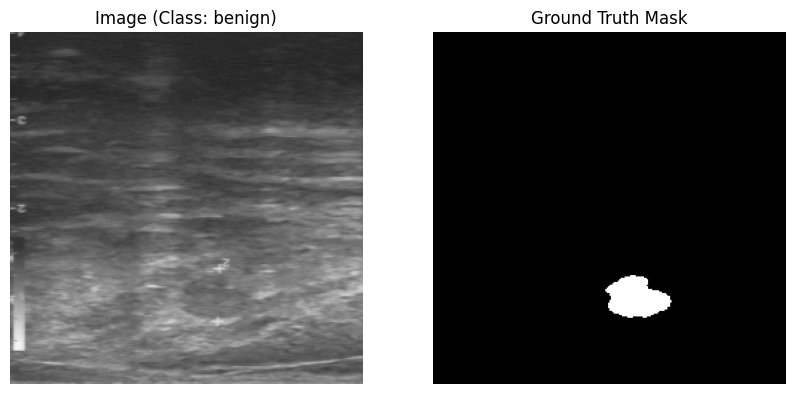

In [ ]:
# Visualize a sample from the dataset to confirm augmentations are working
def show_sample(image, mask, label):
    _, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Image needs to be permuted back to (H, W, C) for matplotlib
    # and normalized if needed (not necessary here as we haven't normalized yet)
    ax[0].imshow(image.permute(1, 2, 0).numpy().astype(np.uint8))
    ax[0].set_title(f"Image (Class: {REV_LABEL_MAP[label.item()]})")
    ax[0].axis('off')

    # Mask is (1, H, W), so we squeeze the channel dimension
    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')

    plt.show()

print("\nDisplaying a random augmented sample from the training set...")
show_sample(image, mask, label)

### Create DataLoaders

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nCreated Train DataLoader with {len(train_loader)} batches.")
print(f"Created Validation DataLoader with {len(val_loader)} batches.")


Created Train DataLoader with 156 batches.
Created Validation DataLoader with 39 batches.


In [ ]:
# We'll use the same imports and configurations from the previous step
# (os, pd, np, cv2, torch, train_test_split, A, plt, etc.)

from torch.utils.data import Dataset, DataLoader

### Refined Custom Dataset for Multi-Task Learning

In [ ]:
# --- 1. Refined Custom Dataset for Multi-Task Learning ---

# We rename the class to be more descriptive of its multi-task purpose
class BreastCancerDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the file paths and label from the dataframe row
        row = self.df.iloc[idx]
        image_path = row.image_path
        mask_path = row.mask_path

        # --- Load Image and Mask ---
        # Read the image and convert to RGB (standard for most models)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read the mask as a single grayscale channel
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # Ensure the mask is binary (0 or 1) and expand its dimensions to (H, W, 1)
        # This is necessary for albumentations to treat it like an image.
        mask = np.expand_dims((mask > 0).astype(np.float32), axis=-1)

        # --- Apply Augmentations ---
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # --- Format for PyTorch ---
        # Transpose from (H, W, C) to (C, H, W) as PyTorch expects
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        # Normalize pixel values to [0, 1] range and convert to Tensors
        image = torch.from_numpy(image) / 255.0
        mask = torch.from_numpy(mask)

        # Get the classification label as a tensor
        label = torch.tensor(row.label, dtype=torch.long)

        # Return all three components needed for multi-task training
        return {
            'image': image,
            'mask': mask,
            'label': label
        }

### Instantiate Datasets and DataLoaders

In [ ]:
# --- 2. Instantiate Datasets and DataLoaders ---

# Use the train_df and val_df we created earlier
train_dataset = BreastCancerDataset(train_df, augmentations=get_train_augs())
val_dataset = BreastCancerDataset(val_df, augmentations=get_val_augs())

print(f"Size of Training Dataset: {len(train_dataset)}")
print(f"Size of Validation Dataset: {len(val_dataset)}")

# Create PyTorch DataLoaders to handle batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nCreated Train DataLoader with {len(train_loader)} batches of size {BATCH_SIZE}.")
print(f"Created Validation DataLoader with {len(val_loader)} batches of size {BATCH_SIZE}.")

Size of Training Dataset: 2492
Size of Validation Dataset: 624

Created Train DataLoader with 156 batches of size 16.
Created Validation DataLoader with 39 batches of size 16.


### Verify the Output


Displaying 5 random augmented samples from the training set...


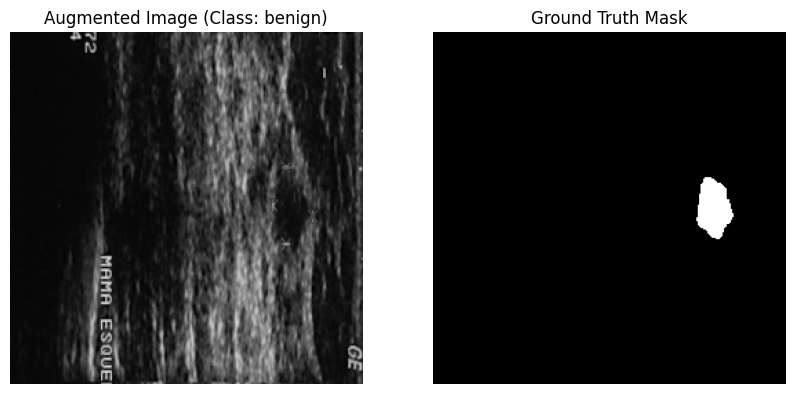

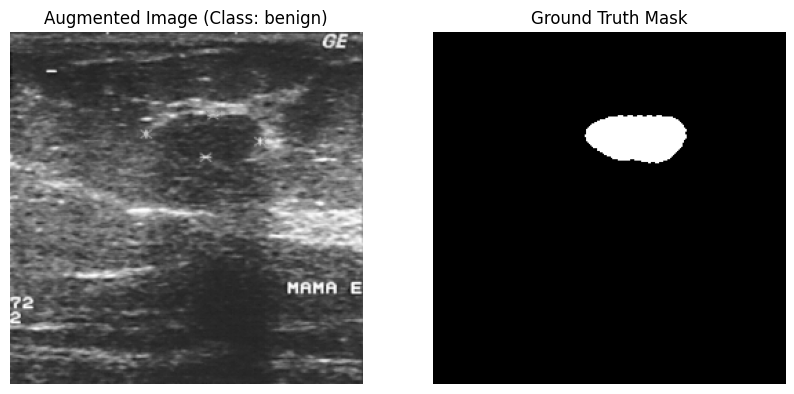

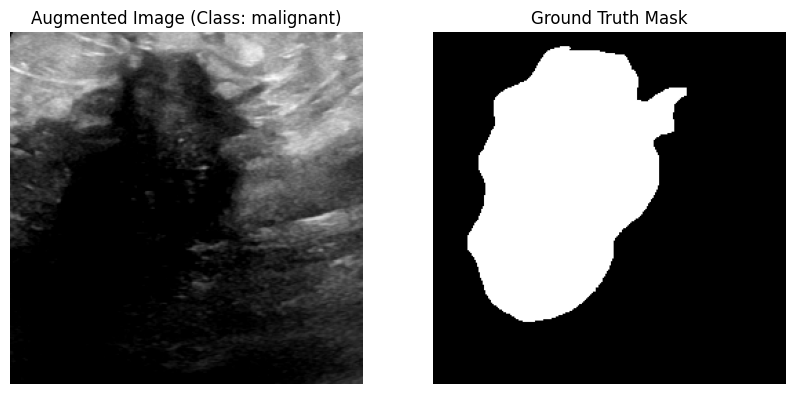

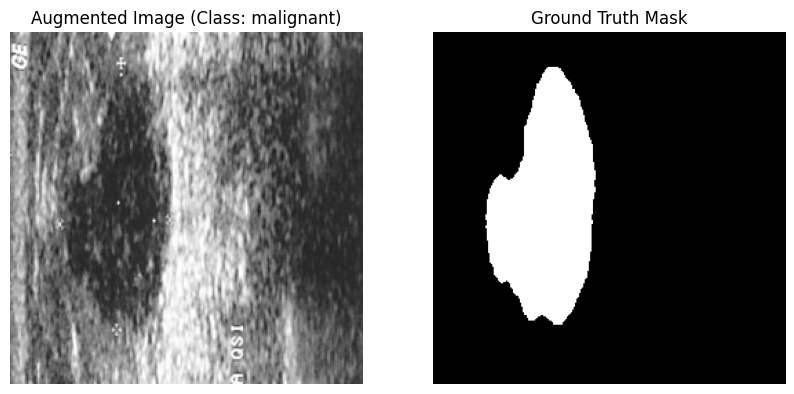

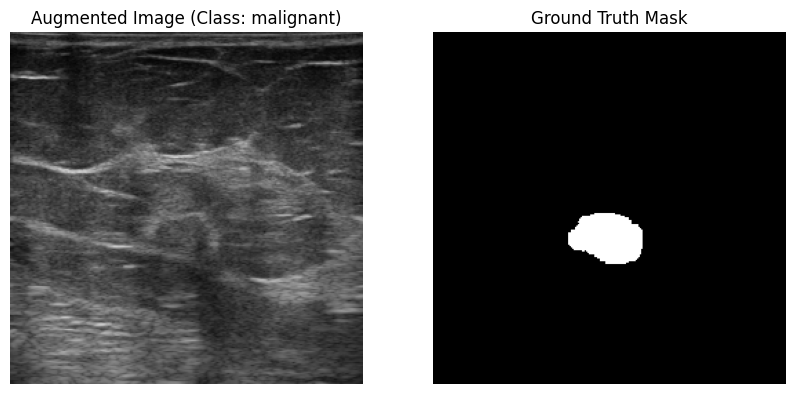

In [ ]:
# --- 3. Verify the Output ---

# An improved visualization function to check all outputs (image, mask, and label)
def show_sample(dataset, idx):
    # Retrieve data as a dictionary
    sample = dataset[idx]
    image, mask, label = sample['image'], sample['mask'], sample['label']

    # Get the string name for the label for the title
    class_name = REV_LABEL_MAP[label.item()]

    # Create plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # Transpose image back to (H, W, C) for displaying
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Augmented Image (Class: {class_name})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    # Squeeze mask to (H, W) for grayscale display
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.show()

# Visualize 5 random samples from the training dataset to ensure everything is correct
print("\nDisplaying 5 random augmented samples from the training set...")
for _ in range(5):
    random_idx = np.random.randint(0, len(train_dataset))
    show_sample(train_dataset, random_idx)

## Defining and Training the Multi-Task Model

This section covers creating the model architecture, defining the training/evaluation functions, and running the main training loop.

In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from tqdm.auto import tqdm # For nice progress bars

## Create Train and Validation Function

In [ ]:
# --- 1. Define the Multi-Task Model ---

# We modify your 'SegmentationModel' to handle both segmentation and classification.
class MultiTaskUnet(nn.Module):
    """
    A U-Net based model with two heads:
    1. Segmentation Head: Outputs a pixel-wise mask (using the U-Net++ decoder).
    2. Classification Head: Outputs a class prediction (benign, malignant, normal).
    """
    def __init__(self, encoder_name, encoder_weights, in_channels, num_classes):
        super(MultiTaskUnet, self).__init__()

        # --- Segmentation Branch ---
        # This is the U-Net++ model you chose. It will act as our primary feature
        # extractor and segmentation decoder.
        self.segmentation_model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=1, # We output 1 channel for the binary mask
            activation=None
        )

        # --- Classification Branch ---
        # We'll create a simple classification head that takes the powerful features
        # from the U-Net's encoder bottleneck and uses them to classify the image.

        # Get the number of output channels from the encoder's last stage
        encoder_out_channels = self.segmentation_model.encoder.out_channels[-1]

        self.classification_head = nn.Sequential(
            # Use Adaptive Average Pooling to handle any feature map size
            nn.AdaptiveAvgPool2d(output_size=1),
            # Flatten the features into a vector
            nn.Flatten(),
            # A final linear layer to map features to the number of classes
            nn.Linear(encoder_out_channels, num_classes)
        )

    def forward(self, images, masks=None, labels=None):
        # --- Segmentation Path ---
        # Get the mask prediction from the U-Net++ decoder
        segmentation_logits = self.segmentation_model(images)

        # --- Classification Path ---
        # Get the features from the encoder's last stage (the bottleneck)
        encoder_features = self.segmentation_model.encoder(images)[-1]
        # Pass these features through our classification head
        classification_logits = self.classification_head(encoder_features)

        # --- Loss Calculation (during training) ---
        if masks is not None and labels is not None:
            # Segmentation Loss: A combination of Dice and BCE is robust.
            seg_loss_dice = DiceLoss(mode='binary')(segmentation_logits, masks)
            seg_loss_bce = nn.BCEWithLogitsLoss()(segmentation_logits, masks)
            segmentation_loss = seg_loss_dice + seg_loss_bce

            # Classification Loss: CrossEntropyLoss is standard for multi-class classification.
            classification_loss = nn.CrossEntropyLoss()(classification_logits, labels)

            # Combine the losses. You can weight them if one task is more important.
            # For now, we'll sum them equally.
            total_loss = segmentation_loss + classification_loss

            return segmentation_logits, classification_logits, total_loss

        # During inference, just return the predictions
        return segmentation_logits, classification_logits

# Instantiate the model with our parameters
model = MultiTaskUnet(
    encoder_name=ENCODER,
    encoder_weights=WEIGHTS,
    in_channels=3,
    num_classes=len(LABEL_MAP) # 3 classes: benign, malignant, normal
)
model.to(DEVICE)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

MultiTaskUnet(
  (segmentation_model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

In [ ]:
# --- 2. Define Training and Evaluation Functions ---

# Updated to handle the dictionary batch and multi-task outputs
def train_model(data_loader, model, optimizer):
    model.train() # Set the model to training mode
    total_loss = 0.0

    # Wrap the data_loader with tqdm for a progress bar
    for batch in tqdm(data_loader, desc="Training"):
        # Unpack the dictionary and move data to the selected device
        images = batch['image'].to(DEVICE)
        masks = batch['mask'].to(DEVICE)
        labels = batch['label'].to(DEVICE)

        optimizer.zero_grad()

        # Forward pass: the model returns segmentation logits, classification logits, and total loss
        _, _, loss = model(images, masks, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
# Updated to handle the dictionary batch and multi-task outputs
def eval_model(data_loader, model):
    model.eval() # Set the model to evaluation mode
    total_loss = 0.0

    with torch.no_grad(): # Disable gradient calculations for efficiency
        # Wrap the data_loader with tqdm for a progress bar
        for batch in tqdm(data_loader, desc="Validating"):
            # Unpack the dictionary and move data to the selected device
            images = batch['image'].to(DEVICE)
            masks = batch['mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            # Forward pass to get the combined loss
            _, _, loss = model(images, masks, labels)

            total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
# --- 3. Run the Training Loop ---

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# We'll use a learning rate scheduler to reduce LR when learning plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

best_val_loss = float('inf') # Initialize with a very high value

print("--- Starting Model Training ---")

for epoch in range(EPOCHS):
    train_loss = train_model(train_loader, model, optimizer)
    val_loss = eval_model(val_loader, model)

    # Update the learning rate scheduler based on the validation loss
    scheduler.step(val_loss)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train Combined Loss: {train_loss:.4f}")
    print(f"  Val Combined Loss  : {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model's state dictionary when we find a new best validation loss
        torch.save(model.state_dict(), 'best_multitask_model.pt')
        print("  -> New best model found! SAVED to 'best_multitask_model.pt'")

    print("-" * 30)

print("--- Training Complete ---")
print(f"Best Validation Loss achieved: {best_val_loss:.4f}")

--- Starting Model Training ---


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^Exception ignored in: ^^^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>^^
^^^^^^^^^^^^^^^^^^
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 1/22
  Train Combined Loss: 2.3029
  Val Combined Loss  : 1.6176
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>
<function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
self._shutdown_workers()    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():
 
          ^   ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3


Epoch 2/22
  Train Combined Loss: 1.6421
  Val Combined Loss  : 1.3695
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 3/22
  Train Combined Loss: 1.3699
  Val Combined Loss  : 1.1156
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    if w.is_alive():

            ^^^^ ^ ^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^^^^^
   File "/usr/lib/pytho

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 4/22
  Train Combined Loss: 1.1768
  Val Combined Loss  : 1.0095
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers()^^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():
^ ^^  ^ ^ ^  ^^^^^^^^^^^^^


Epoch 5/22
  Train Combined Loss: 1.0244
  Val Combined Loss  : 0.8687
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 6/22
  Train Combined Loss: 0.9233
  Val Combined Loss  : 0.7776
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 7/22
  Train Combined Loss: 0.8396
  Val Combined Loss  : 0.7917
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 8/22
  Train Combined Loss: 0.8064
  Val Combined Loss  : 0.7333
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 9/22
  Train Combined Loss: 0.7233
  Val Combined Loss  : 0.8372
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 10/22
  Train Combined Loss: 0.6958
  Val Combined Loss  : 0.6458
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 11/22
  Train Combined Loss: 0.6758
  Val Combined Loss  : 0.7092
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 12/22
  Train Combined Loss: 0.6275
  Val Combined Loss  : 0.6584
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 13/22
  Train Combined Loss: 0.5903
  Val Combined Loss  : 0.6491
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 14/22
  Train Combined Loss: 0.5773
  Val Combined Loss  : 0.6324
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 15/22
  Train Combined Loss: 0.5510
  Val Combined Loss  : 0.6569
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 16/22
  Train Combined Loss: 0.5252
  Val Combined Loss  : 0.6838
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 17/22
  Train Combined Loss: 0.5112
  Val Combined Loss  : 0.6134
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 18/22
  Train Combined Loss: 0.5191
  Val Combined Loss  : 0.5998
  -> New best model found! SAVED to 'best_multitask_model.pt'
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
     Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78df2c14bb00> 
 ^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^^    self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
^ ^^ ^   ^  ^^^^^^
^^^^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
  ^
   File "/usr/lib/pyt


Epoch 19/22
  Train Combined Loss: 0.5131
  Val Combined Loss  : 0.6097
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 20/22
  Train Combined Loss: 0.4968
  Val Combined Loss  : 0.6870
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 21/22
  Train Combined Loss: 0.4788
  Val Combined Loss  : 0.6332
------------------------------


Training:   0%|          | 0/156 [00:00<?, ?it/s]

Validating:   0%|          | 0/39 [00:00<?, ?it/s]


Epoch 22/22
  Train Combined Loss: 0.4566
  Val Combined Loss  : 0.6370
------------------------------
--- Training Complete ---
Best Validation Loss achieved: 0.5998


## Inference and Visualizing Predictions

In this section, we load our best-performing model and use it to make predictions on images from the validation set. We then visualize these predictions alongside the ground truth to qualitatively assess the model's performance on both segmentation and classification tasks.

In [ ]:
# --- 1. Load the Best Model ---

# First, we need to instantiate the model architecture again
# This must be the same architecture that was saved.
model = MultiTaskUnet(
    encoder_name=ENCODER,
    encoder_weights=WEIGHTS,
    in_channels=3,
    num_classes=len(LABEL_MAP)
)

# Load the saved weights from our training loopi
# Make sure the file 'best_multitask_model.pt' is in the correct directory.
try:
    model.load_state_dict(torch.load('best_multitask_model.pt', map_location=DEVICE))
    print("Model loaded successfully from 'best_multitask_model.pt'")
except FileNotFoundError:
    print("Error: 'best_multitask_model.pt' not found. Please ensure the model was trained and saved correctly.")
    # Exit or handle the error as needed

# Move the model to the correct device
model.to(DEVICE)
# Set the model to evaluation mode. This is crucial as it disables things like dropout.
model.eval()

Model loaded successfully from 'best_multitask_model.pt'


MultiTaskUnet(
  (segmentation_model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

In [ ]:
# --- 2. Define the Inference and Visualization Function ---

def visualize_prediction(dataset, idx):
    """
    Performs inference on a single sample from the dataset and visualizes
    the image, ground truth, and prediction for both segmentation and classification.
    """
    # Retrieve the data sample as a dictionary
    sample = dataset[idx]
    image, gt_mask, gt_label_idx = sample['image'], sample['mask'], sample['label']

    # Prepare the image for the model: add a batch dimension (1, C, H, W)
    # and move it to the device where the model is.
    input_image = image.to(DEVICE).unsqueeze(0)

    # Perform inference within a no_grad() block for efficiency
    with torch.no_grad():
        # Our model returns two outputs: segmentation logits and classification logits
        seg_logits, class_logits = model(input_image)

    # --- Process Segmentation Output ---
    # Apply sigmoid to get probabilities and threshold at 0.5 to get a binary mask
    pred_mask = torch.sigmoid(seg_logits)
    pred_mask = (pred_mask > 0.5).float()

    # --- Process Classification Output ---
    # Get the predicted class index by finding the position of the highest logit
    pred_label_idx = torch.argmax(class_logits, dim=1).item()

    # Convert ground truth and predicted indices back to their string names for display
    gt_label_name = REV_LABEL_MAP[gt_label_idx.item()]
    pred_label_name = REV_LABEL_MAP[pred_label_idx]

    # Determine if the classification was correct for title coloring
    class_color = 'green' if gt_label_name == pred_label_name else 'red'

    # --- Plotting ---
    plt.figure(figsize=(15, 5))

    # Plot 1: Original Image with Classification Results
    plt.subplot(1, 3, 1)
    # Transpose image from (C,H,W) to (H,W,C) for matplotlib
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"IMAGE\nGT Class: {gt_label_name}\nPred Class: {pred_label_name}", color=class_color)
    plt.axis('off')

    # Plot 2: Ground Truth Mask
    plt.subplot(1, 3, 2)
    # Squeeze mask from (1,H,W) to (H,W) for grayscale display
    plt.imshow(gt_mask.squeeze(), cmap='gray')
    plt.title('GROUND TRUTH MASK')
    plt.axis('off')

    # Plot 3: Predicted Mask
    plt.subplot(1, 3, 3)
    # Move the predicted mask tensor to CPU, detach from graph, and format for plotting
    pred_mask_to_plot = pred_mask.detach().cpu().squeeze()
    plt.imshow(pred_mask_to_plot, cmap='gray')
    plt.title('PREDICTED MASK')
    plt.axis('off')

    plt.show()

### Run Inference on Random Samples


--- Displaying random predictions from the validation set ---


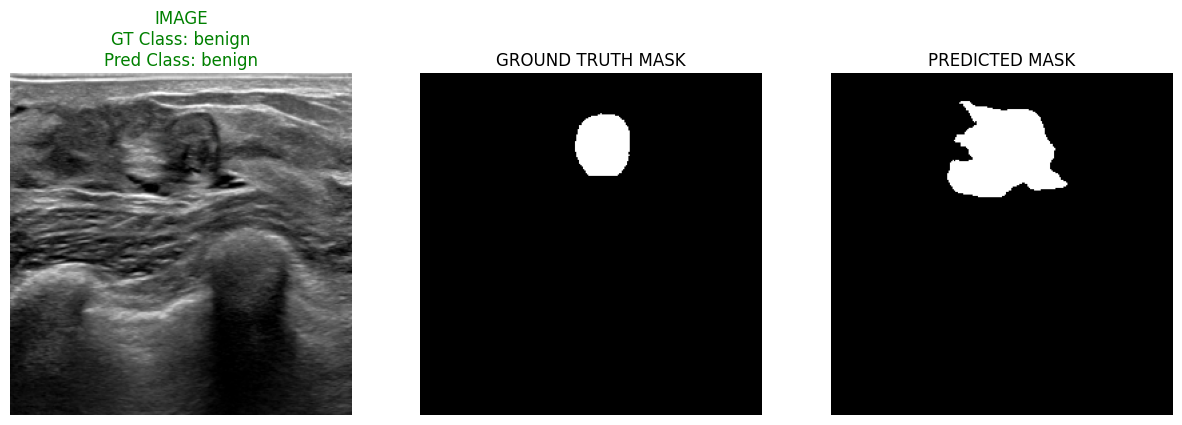

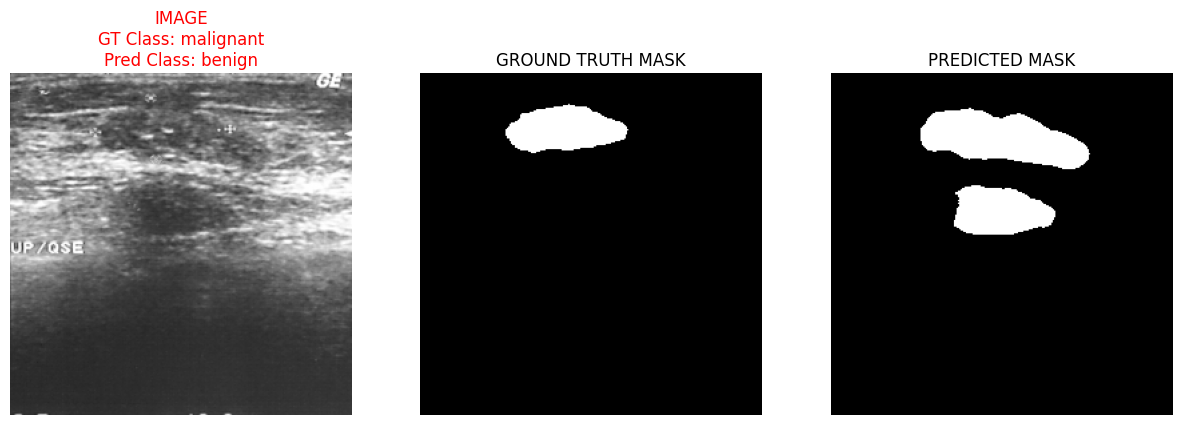

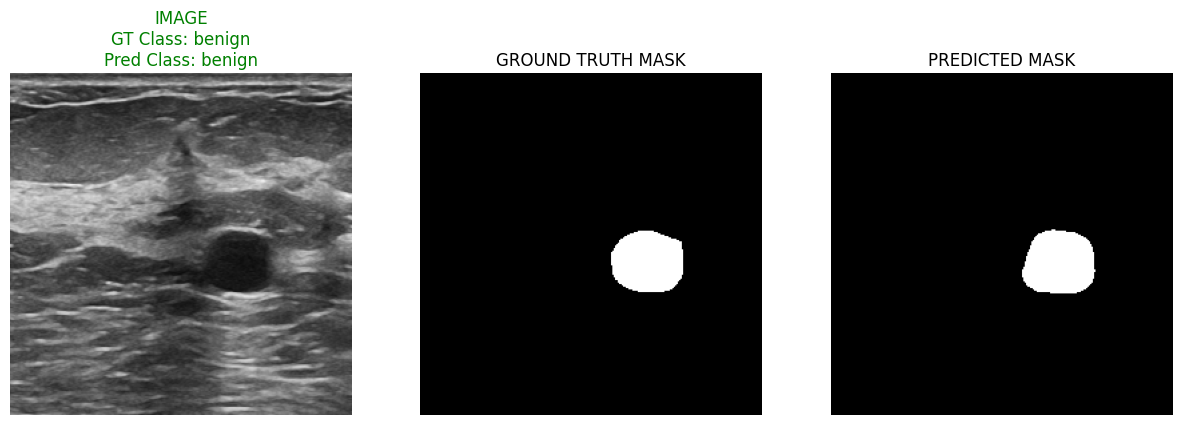

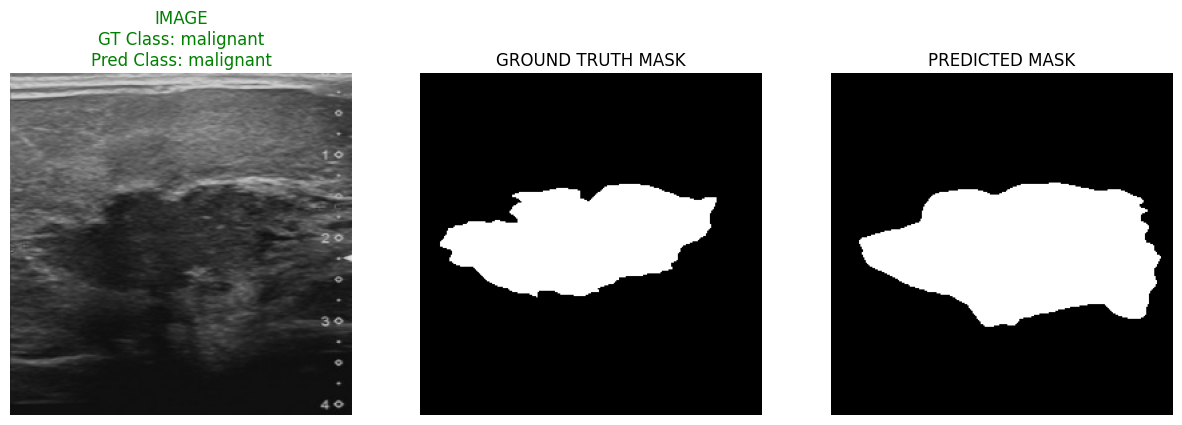

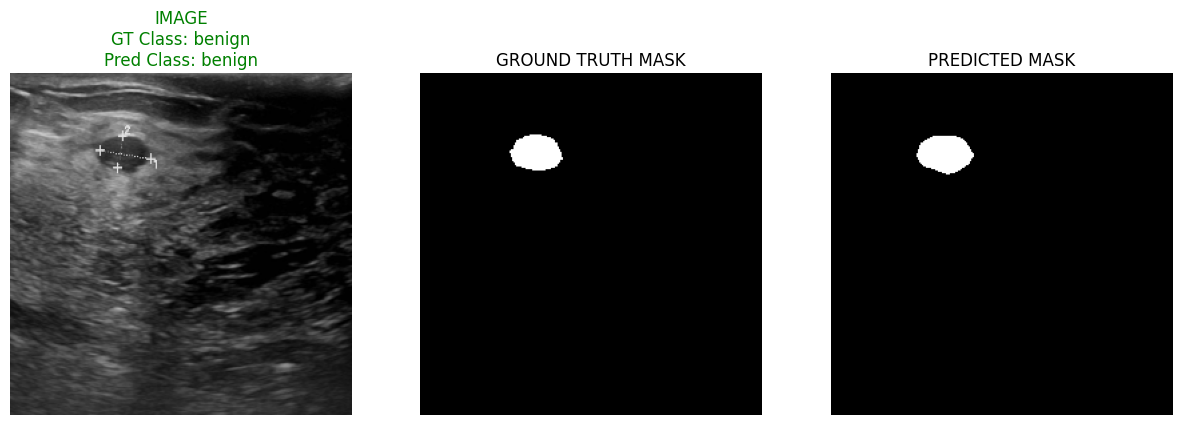

In [ ]:
# --- 3. Run Inference on Random Samples ---

# Visualize predictions for 5 random images from the validation set
print("\n--- Displaying random predictions from the validation set ---")
# Use val_dataset which has no random augmentations for cleaner visuals
for _ in range(5):
    random_idx = np.random.randint(0, len(val_dataset))
    visualize_prediction(val_dataset, random_idx)

In [ ]:
# --- 1. Setup: Load Model and Prepare for Evaluation ---

# Instantiate the model architecture (must match the saved model)
model = MultiTaskUnet(
    encoder_name=ENCODER,
    encoder_weights=WEIGHTS,
    in_channels=3,
    num_classes=len(LABEL_MAP)
)

# Load the saved state dictionary
try:
    model.load_state_dict(torch.load('best_multitask_model.pt', map_location=DEVICE))
    print("Best model loaded successfully from 'best_multitask_model.pt'")
except FileNotFoundError:
    raise RuntimeError("Model file not found. Please ensure training was completed and the model was saved.")

Best model loaded successfully from 'best_multitask_model.pt'


In [ ]:
# Move model to the device and set to evaluation mode
model.to(DEVICE)
model.eval()

MultiTaskUnet(
  (segmentation_model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         

In [ ]:
# --- 2. Run Inference on the Entire Validation Set ---

# We will collect all ground truths and predictions to calculate metrics at the end
all_gt_masks = []
all_pred_masks = []
all_gt_labels = []
all_pred_labels = []

# Use the val_loader (with shuffle=False)
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating on Validation Set"):
        images = batch['image'].to(DEVICE)
        gt_masks = batch['mask'].to(DEVICE)
        gt_labels = batch['label']

        # Get model predictions
        seg_logits, class_logits = model(images)

        # Process segmentation predictions
        pred_masks = (torch.sigmoid(seg_logits) > 0.5).float()

        # Process classification predictions
        pred_labels = torch.argmax(class_logits, dim=1)

        # Append results to our lists (move to CPU to avoid filling GPU memory)
        all_gt_masks.extend(list(gt_masks.cpu()))
        all_pred_masks.extend(list(pred_masks.cpu()))
        all_gt_labels.extend(list(gt_labels.numpy()))
        all_pred_labels.extend(list(pred_labels.cpu().numpy()))

Evaluating on Validation Set:   0%|          | 0/39 [00:00<?, ?it/s]

In [ ]:
# --- 3. Calculate and Display Segmentation Metrics ---

def calculate_dice_iou(pred_mask, gt_mask, epsilon=1e-6):
    """Calculates Dice Score and IoU for a single mask pair."""
    # Ensure tensors are boolean/float for calculations
    pred_mask = pred_mask.bool()
    gt_mask = gt_mask.bool()

    intersection = (pred_mask & gt_mask).float().sum()
    union = (pred_mask | gt_mask).float().sum()

    dice_score = (2. * intersection) / (pred_mask.sum() + gt_mask.sum() + epsilon)
    iou_score = intersection / (union + epsilon)

    return dice_score.item(), iou_score.item()

In [ ]:
# Calculate metrics for all masks and find the average
dice_scores = []
iou_scores = []
for pred_m, gt_m in zip(all_pred_masks, all_gt_masks):
    dice, iou = calculate_dice_iou(pred_m, gt_m)
    dice_scores.append(dice)
    iou_scores.append(iou)

avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)

print("\n--- Segmentation Metrics (Validation Set) ---")
print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average IoU (Jaccard Index): {avg_iou:.4f}")


--- Segmentation Metrics (Validation Set) ---
Average Dice Score: 0.7779
Average IoU (Jaccard Index): 0.7013


In [ ]:
# --- 4. Calculate and Display Classification Metrics ---

# Generate the classification report (precision, recall, f1-score)
class_names = list(LABEL_MAP.keys())
report = classification_report(all_gt_labels, all_pred_labels, target_names=class_names)

print("\n--- Classification Metrics (Validation Set) ---")
print(report)


--- Classification Metrics (Validation Set) ---
              precision    recall  f1-score   support

      benign       0.90      0.94      0.92       387
   malignant       0.87      0.77      0.82       191
      normal       0.94      0.98      0.96        46

    accuracy                           0.89       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.89      0.89      0.89       624



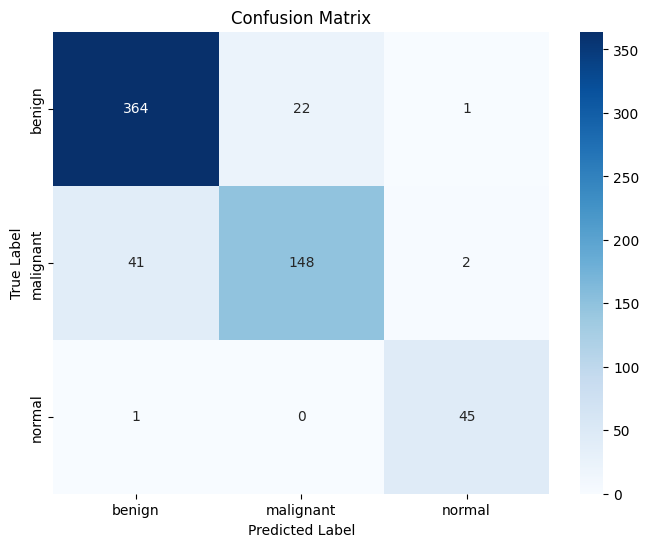

In [ ]:
# Generate and plot the confusion matrix
cm = confusion_matrix(all_gt_labels, all_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def visualize_overlay(dataset, idx):
    """Performs inference and visualizes:
       1. Original Image
       2. Ground Truth Mask
       3. Prediction Mask (hard overlay)
       4. Prediction Overlay (blended, purple)
    """
    sample = dataset[idx]
    image, gt_mask, gt_label_idx = sample['image'], sample['mask'], sample['label']

    # Perform inference
    with torch.no_grad():
        seg_logits, class_logits = model(image.to(DEVICE).unsqueeze(0))
        pred_mask = (torch.sigmoid(seg_logits) > 0.5).float().cpu()
        pred_label_idx = torch.argmax(class_logits, dim=1).item()

    # Get class names for titles
    gt_label_name = REV_LABEL_MAP[gt_label_idx.item()]
    pred_label_name = REV_LABEL_MAP[pred_label_idx]

    # --- Prepare Image ---
    image_np = image.permute(1, 2, 0).numpy()
    if image_np.max() <= 1.0:  # scale if needed
        image_np = (image_np * 255).astype(np.uint8)
    else:
        image_np = image_np.astype(np.uint8)

    # --- Create Prediction Mask (hard overlay, light blue) ---
    hard_overlay_img = image_np.copy()
    mask_np = pred_mask.squeeze().numpy().astype(bool)
    hard_overlay_img[mask_np] = [173, 216, 230]  # light blue (RGB for matplotlib)

    # --- Create Blended Overlay (semi-transparent purple) ---
    mask_color = np.zeros_like(image_np)
    overlay_color = (128, 0, 128)  # purple (BGR for cv2)
    mask_color[mask_np] = overlay_color
    blended_overlay_bgr = cv2.addWeighted(image_np, 0.7, mask_color, 0.7, 0)
    blended_overlay = cv2.cvtColor(blended_overlay_bgr, cv2.COLOR_BGR2RGB)

    # --- Plotting ---
    plt.figure(figsize=(20, 5))

    # 1. Original
    plt.subplot(1, 4, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Original Image\n(GT: {gt_label_name})")
    plt.axis('off')

    # 2. Ground Truth
    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # 3. Prediction (hard overlay)
    plt.subplot(1, 4, 3)
    plt.imshow(hard_overlay_img)
    plt.title(f"Prediction Mask\n(Pred: {pred_label_name})")
    plt.axis('off')

    # 4. Prediction (blended purple overlay)
    plt.subplot(1, 4, 4)
    plt.imshow(blended_overlay)
    plt.title("Prediction Overlay (Purple)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



--- Visualizing Predictions with Mask Overlay ---


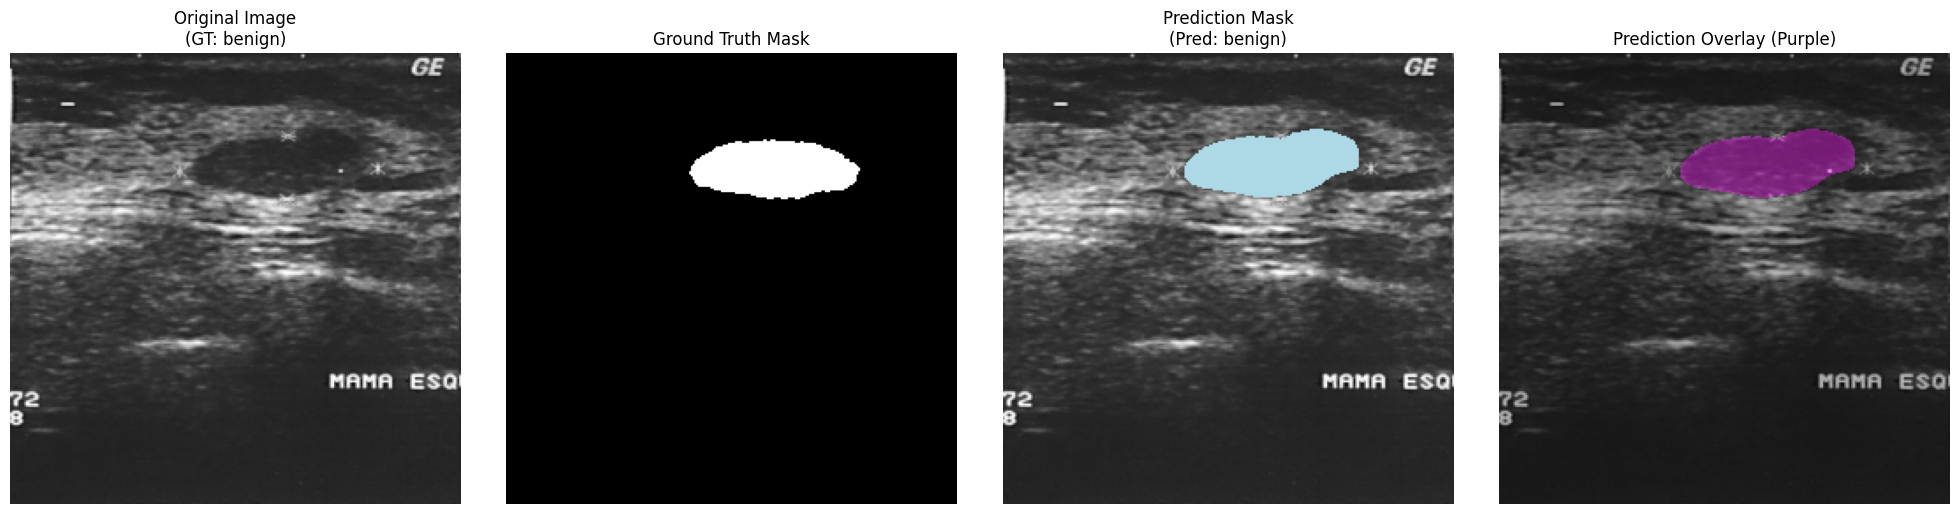

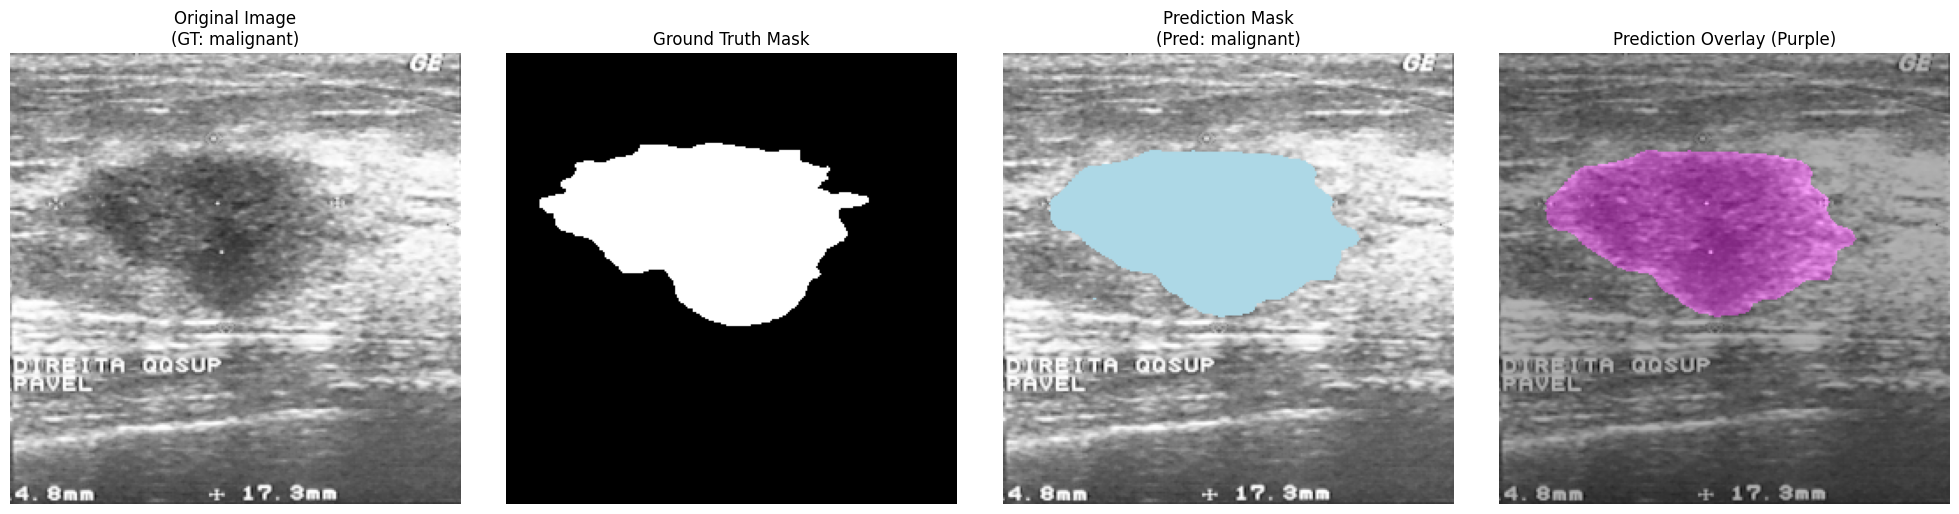

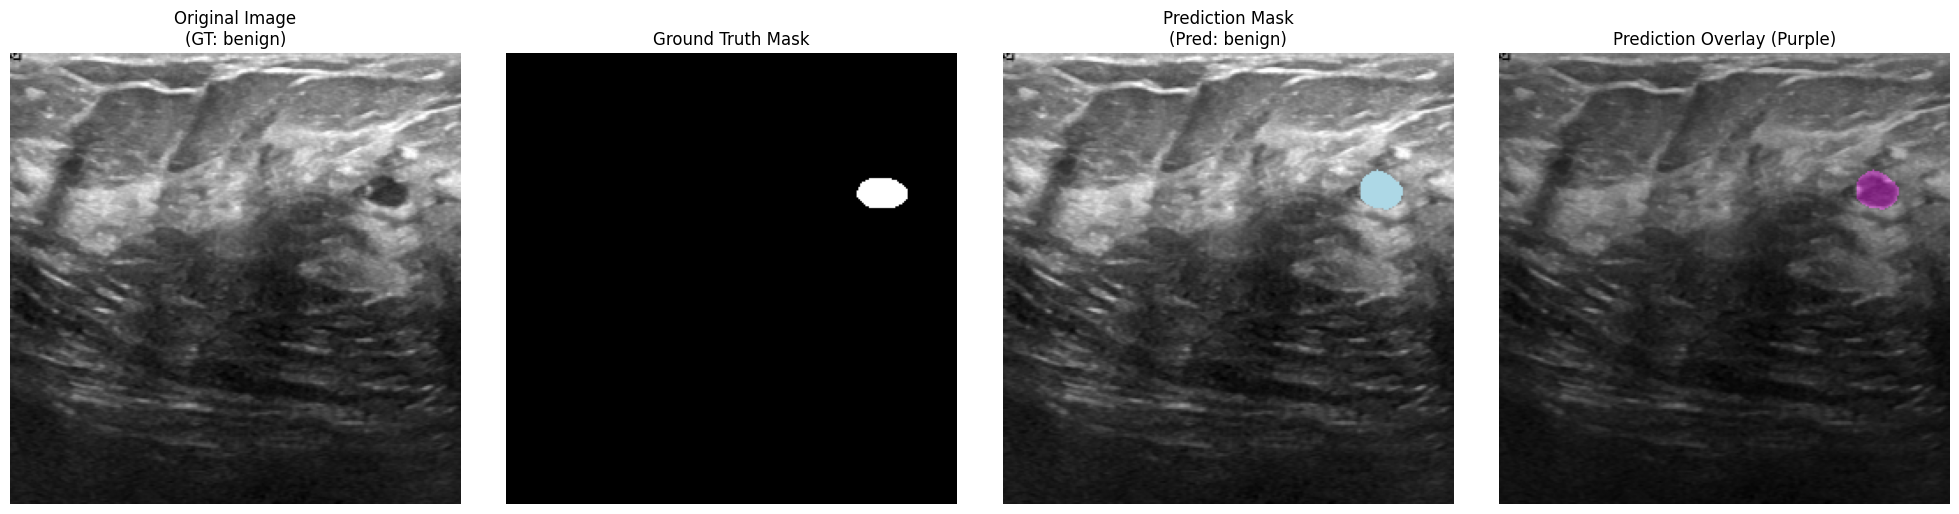

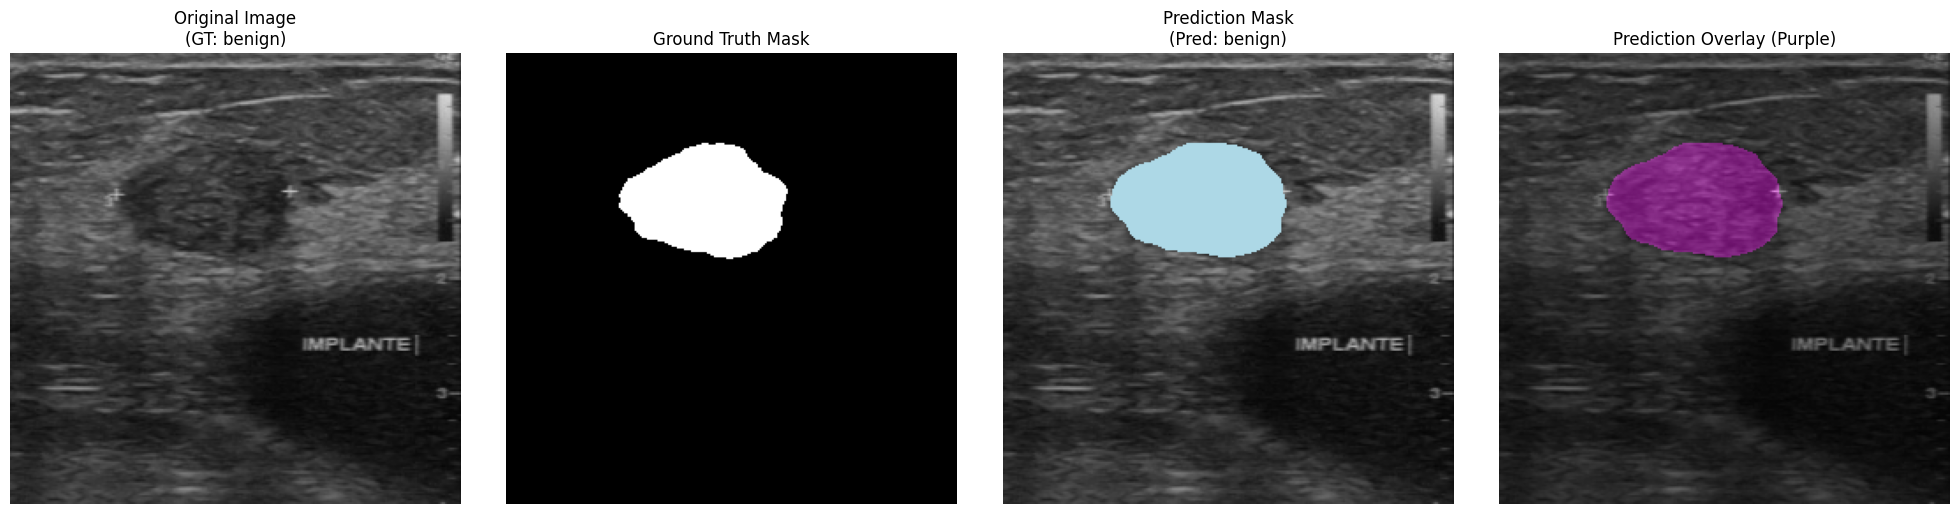

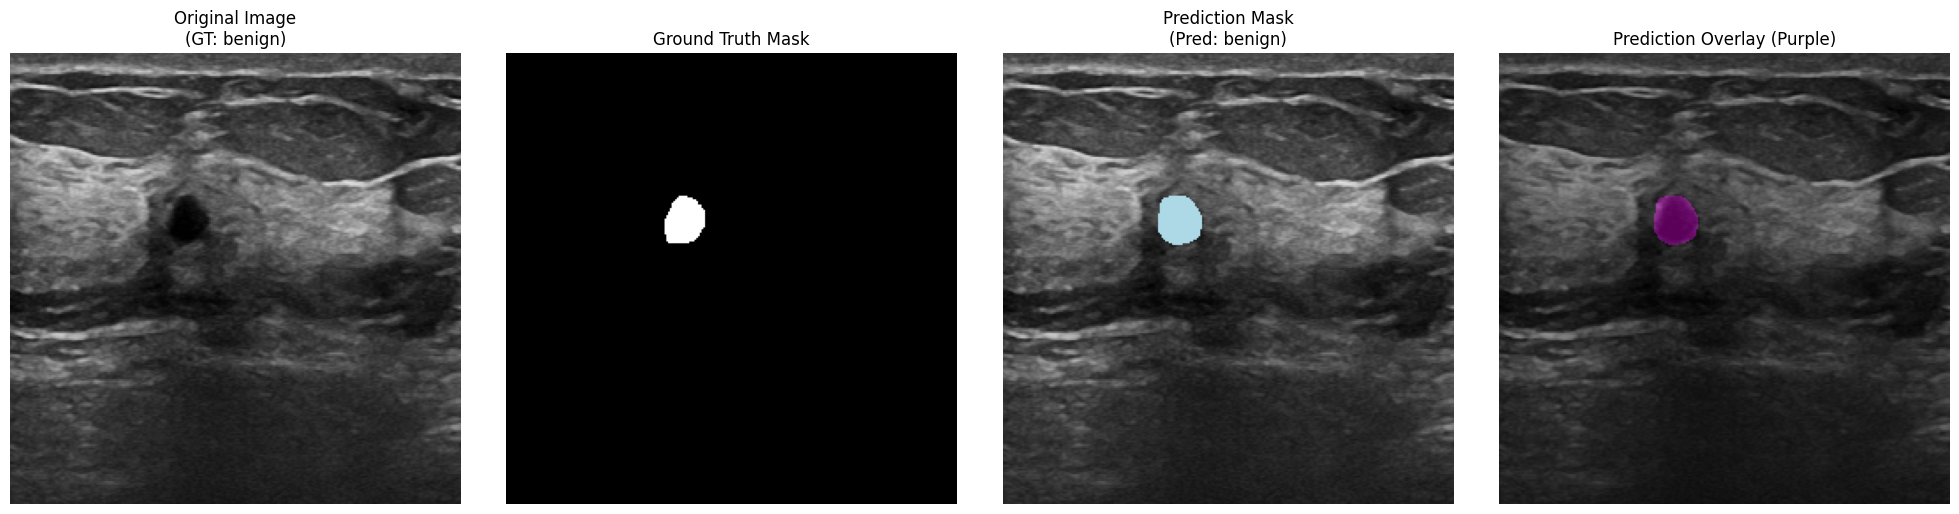

In [ ]:
# Visualize a few random examples with the overlay
print("\n--- Visualizing Predictions with Mask Overlay ---")
for _ in range(5):
    random_idx = np.random.randint(0, len(val_dataset))
    visualize_overlay(val_dataset, random_idx)

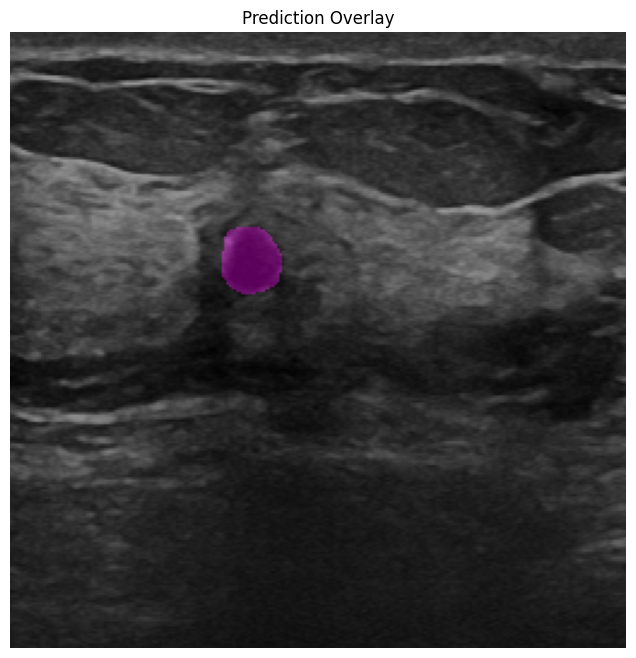

array([[[56, 56, 56],
        [52, 52, 52],
        [50, 50, 50],
        ...,
        [53, 53, 53],
        [50, 50, 50],
        [47, 47, 47]],

       [[48, 48, 48],
        [49, 49, 49],
        [53, 53, 53],
        ...,
        [46, 46, 46],
        [47, 47, 47],
        [47, 47, 47]],

       [[59, 59, 59],
        [52, 52, 52],
        [49, 49, 49],
        ...,
        [50, 50, 50],
        [51, 51, 51],
        [54, 54, 54]],

       ...,

       [[26, 26, 26],
        [28, 28, 28],
        [32, 32, 32],
        ...,
        [28, 28, 28],
        [31, 31, 31],
        [29, 29, 29]],

       [[26, 26, 26],
        [26, 26, 26],
        [28, 28, 28],
        ...,
        [26, 26, 26],
        [22, 22, 22],
        [23, 23, 23]],

       [[26, 26, 26],
        [30, 30, 30],
        [33, 33, 33],
        ...,
        [19, 19, 19],
        [19, 19, 19],
        [24, 24, 24]]], dtype=uint8)
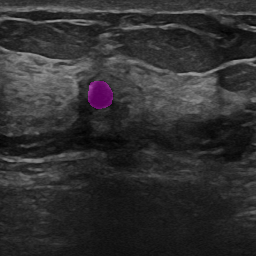

In [ ]:
def visualize_single_overlay(dataset, idx):
    sample = dataset[idx]
    image, gt_mask, gt_label_idx = sample['image'], sample['mask'], sample['label']

    # Perform inference
    with torch.no_grad():
        seg_logits, class_logits = model(image.to(DEVICE).unsqueeze(0))
        pred_mask = (torch.sigmoid(seg_logits) > 0.5).float().cpu()

    # --- Convert original tensor to uint8 image ---
    image_np = image.permute(1, 2, 0).numpy()

    # If image is in [0,1] range, scale it up
    if image_np.max() <= 1.0:
        image_np = (image_np * 255).astype(np.uint8)
    else:
        image_np = image_np.astype(np.uint8)

    # --- Create color mask ---
    mask_color = np.zeros_like(image_np)
    # overlay_color = (173, 216, 230)  # light blue (BGR for OpenCV)
    overlay_color = (128, 0, 128)  # purple (BGR format)
    mask_np_bool = pred_mask.squeeze().numpy().astype(bool)
    mask_color[mask_np_bool] = overlay_color

    # --- Blend overlay ---
    alpha, beta, gamma = 0.7, 0.7, 0.5
    overlaid_image = cv2.addWeighted(image_np, alpha, mask_color, beta, gamma)

    # Convert for matplotlib
    overlaid_image_rgb = cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB)

    # Show
    plt.figure(figsize=(8, 8))
    plt.imshow(overlaid_image_rgb)
    plt.axis('off')
    plt.title("Prediction Overlay")
    plt.show()

    return overlaid_image_rgb


visualize_single_overlay(val_dataset, random_idx)